## Utilities

In [1]:
from torch import Tensor
from typing import Any, Iterable, Type, TypeVar, cast

T = TypeVar("T")


def assert_type(typ: Type[T], obj: Any) -> T:
    """Assert that an object is of a given type at runtime and return it."""
    if not isinstance(obj, typ):
        raise TypeError(f"Expected {typ.__name__}, got {type(obj).__name__}")

    return cast(typ, obj)


def vector_to_parameter_dict(vec: Tensor, named_params: Iterable[tuple[str, Tensor]]):
    """Convert a flat vector of parameters into to a dictionary of named parameters."""
    param_dict = {}
    i = 0
    for name, param in named_params:
        param_dict[name] = vec[i:i + param.numel()].view_as(param)
        i += param.numel()
    return param_dict

## Load checkpoints from the HuggingFace Hub

In [2]:
from torch.optim import AdamW
from transformers import GPTNeoXTokenizerFast, GPTNeoXForCausalLM
import torch

model0 = assert_type(
    GPTNeoXForCausalLM,
    GPTNeoXForCausalLM.from_pretrained(
        "EleutherAI/pythia-70m", revision="step1000", device_map={"": "cuda:0"}, torch_dtype=torch.float32
    )
)
tokenizer = GPTNeoXTokenizerFast.from_pretrained("EleutherAI/pythia-70m")

/mnt/ssd-1/nora/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import numpy as np

first_batch = torch.from_numpy(np.load("/mnt/ssd-1/nora/first_batch.npy")[:-1].astype(np.int64)).to(model0.device)
second_batch = torch.from_numpy(np.load("/mnt/ssd-1/nora/second_batch.npy")[:-1].astype(np.int64)).to(model0.device)

In [4]:
from functools import partial
from torch.func import functional_call, jvp
import torch


@torch.no_grad
def model_fn(input_ids, param_vec):
    param_dict = vector_to_parameter_dict(param_vec, model0.named_parameters())
    return functional_call(model0, (param_dict, {}), input_ids).logits

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:10<00:00,  8.78s/it]


Text(0, 0.5, 'Cosine similarity')

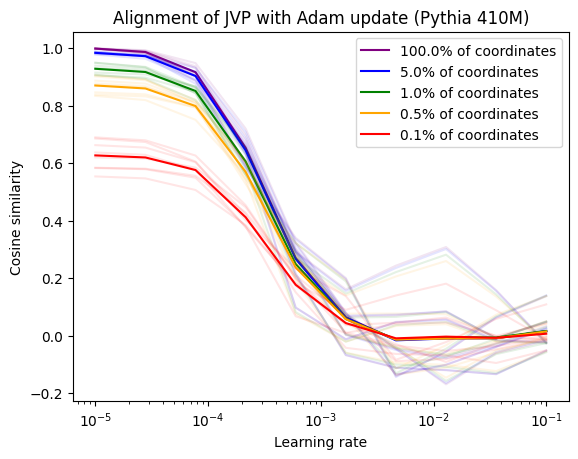

In [5]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Use tensor cores
torch.set_float32_matmul_precision("high")

# Remember the original parameters
params0 = torch.nn.utils.parameters_to_vector(model0.parameters())

NUM_EVAL = 4
NUM_TRAIN = 8
NUM_LRS = 10

grid = torch.logspace(-5, -1, NUM_LRS).tolist()

for p, color in [(0.0, "purple"), (0.99, "green"), (0.995, "orange"), (0.999, "red")]:
    cosines = torch.full((NUM_TRAIN, NUM_LRS), torch.nan)

    for i, example in enumerate(tqdm(first_batch[:NUM_TRAIN])):
        opt = AdamW(
            model0.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=0.1
        )
        model0(example[None], labels=example[None]).loss.backward()

        torch.nn.utils.clip_grad_norm_(model0.parameters(), 1.0)
        grads = torch.nn.utils.parameters_to_vector(p.grad for p in model0.parameters() if p.grad is not None)

        try:
            # Peek at what the step would do
            opt.step()
            opt.zero_grad()
            params1 = torch.nn.utils.parameters_to_vector(model0.parameters())
        finally:
            # Reset the parameters
            torch.nn.utils.vector_to_parameters(params0.clone(), model0.parameters())

        adam_update = params1.sub(params0) / 1e-3
        out0, adam_jvp = assert_type(
            tuple,
            jvp(
                partial(model_fn, second_batch[:NUM_EVAL]),
                primals=(params0,),
                tangents=(F.dropout(adam_update, p=p),)
            )
        )

        # Get alignments for different learning rates
        for j, alpha in enumerate(grid):
            param_ = params0 + adam_update.mul(alpha)
            out_ = model_fn(second_batch[:NUM_EVAL], param_)

            cosines[i, j] = torch.nn.functional.cosine_similarity(adam_jvp.flatten(), out_.sub(out0).flatten(), dim=-1)

        plt.plot(grid, cosines[i], alpha=0.1, c=color)

    plt.plot(grid, cosines.mean(dim=0), c=color, label=f"{1 - p:.1%} of coordinates")

plt.xscale("log")
plt.legend()

plt.title("Alignment of JVP with Adam update (Pythia 70M)")
plt.xlabel("Learning rate")
plt.ylabel("Cosine similarity")